In [64]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [65]:
hidden_dim = 128
original_dim = 784
max_epochs = 20
batch_size = 256
eta = 1e-3
momentum = 8e-1

In [66]:
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

X_train = np.reshape(X_train, (X_train.shape[0], original_dim))
X_test = np.reshape(X_test, (X_test.shape[0], original_dim))
# X_test = np.random.shuffle(X_test)
training_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(60000).batch(batch_size)

In [67]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units = hidden_dim,
            activation = tf.nn.relu, activity_regularizer = tf.keras.regularizers.l1(10e-5))
        
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return activation

In [68]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units = original_dim, activation = tf.nn.relu)
    
    def call(self, encoded_features):
        reconstructed = self.hidden_layer(encoded_features)
        return reconstructed

In [69]:
class AutoEncoder(tf.keras.Model):
    def __init__(self, hidden_dim, original_dim):
        super(AutoEncoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(hidden_dim)
        self.decoder = Decoder(original_dim)
        
    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

In [70]:
autoencoder = AutoEncoder(hidden_dim, original_dim)
opt = tf.optimizers.Adam(learning_rate = eta)

In [71]:
def loss(preds, real):
    return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

In [72]:
def train(model, original, opt):
    with tf.GradientTape() as tape:
        reconstructed = model(original)
        recon_loss = loss(reconstructed, original)
    gradients = tape.gradient(recon_loss, model.trainable_weights)
    gradients_variables = zip(gradients, model.trainable_weights)
    opt.apply_gradients(gradients_variables)
    return recon_loss

In [73]:
def train_loop(model, dataset, opt, epochs):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, batch_features in enumerate(dataset):
            loss_values = train(model, batch_features, opt)
            epoch_loss += loss_values
        model.loss.append(epoch_loss/step)
        print('Epochs: %d, Loss: %.6f' % (epoch, epoch_loss.numpy()))

In [74]:
train_loop(autoencoder, training_dataset, opt, max_epochs)

Epochs: 0, Loss: 5.892091
Epochs: 1, Loss: 1.899281
Epochs: 2, Loss: 1.493314
Epochs: 3, Loss: 1.324784
Epochs: 4, Loss: 1.222508
Epochs: 5, Loss: 1.166285
Epochs: 6, Loss: 1.124863
Epochs: 7, Loss: 1.086475
Epochs: 8, Loss: 1.062794
Epochs: 9, Loss: 1.045334
Epochs: 10, Loss: 1.033882
Epochs: 11, Loss: 1.023013
Epochs: 12, Loss: 1.012395
Epochs: 13, Loss: 1.005548
Epochs: 14, Loss: 0.993956
Epochs: 15, Loss: 0.985428
Epochs: 16, Loss: 0.981316
Epochs: 17, Loss: 0.977882
Epochs: 18, Loss: 0.973383
Epochs: 19, Loss: 0.971104


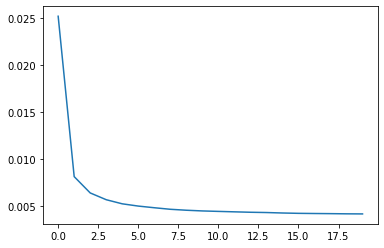

In [75]:
plt.plot(range(max_epochs), autoencoder.loss)
plt.show()

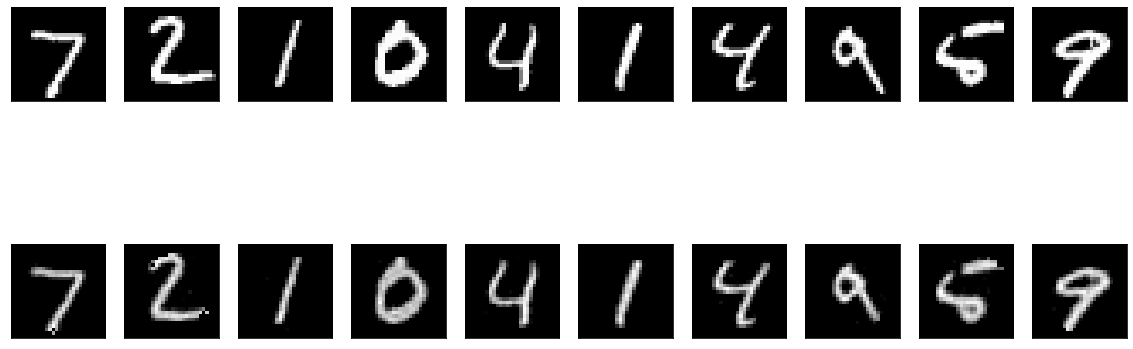

In [76]:
reconstructed = autoencoder(X_test)
number = 10
plt.figure(figsize = (20, 8))
for index in range(number):
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(reconstructed[index].numpy().reshape(28, 28), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()